# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677


When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

### Components setup: Models & Agent

In [5]:
import torch 
from torch import nn, optim
import random
import copy
import numpy as np
from collections import deque
import time
import matplotlib.pyplot as plt

In [44]:
global_seed = 26
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def hidden_init(layer):
    classname = layer.__class__.__name__
    if classname.find('Linear') != -1:
        fan_in = layer.weight.data.size()[0]
        lim = 1. / np.sqrt(fan_in)

        nn.init.uniform_(layer.weight.data, -lim, lim)

class Actor(nn.Module):
    def __init__(self, hidden_size=512):
        super(Actor, self).__init__()
        torch.manual_seed(global_seed)

        self.actor = nn.Sequential(
            nn.BatchNorm1d(24),
            nn.Linear(24, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size//2),
            nn.BatchNorm1d(hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, 2),
            nn.Tanh()
        )

        self.apply(hidden_init)
    
    def forward(self, state):
        return self.actor(state)

class Critic(nn.Module):
    def __init__(self, hidden_size=512):
        super(Critic, self).__init__()
        torch.manual_seed(global_seed)

        self.first_layer = nn.Sequential(
            nn.BatchNorm1d(24),
            nn.Linear(24, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
        )

        self.critic = nn.Sequential(
            nn.Linear(hidden_size+2, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

        self.apply(hidden_init)
    
    def forward(self, state, action):
        p_state = self.first_layer(state)
        action_state = torch.cat((p_state, action), dim=1)
        return self.critic(action_state)

class ReplayBuffer():
    def __init__(self, buffer_size=100000):
        self.buffer = deque(maxlen=buffer_size)
        random.seed(global_seed)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size=256):
        experiences = random.sample(self.buffer, k=batch_size)

        states = torch.tensor([e[0] for e in experiences]).float().to(device)
        actions = torch.tensor([e[1] for e in experiences]).float().to(device)
        rewards = torch.tensor([e[2] for e in experiences]).float().unsqueeze(-1).to(device)
        next_states = torch.tensor([e[3] for e in experiences]).float().to(device)
        dones = torch.tensor([e[4] for e in experiences]).float().to(device)

        return (states, actions, rewards, next_states, dones)

class Agent():
    def __init__(self):
        random.seed(global_seed)

        self.actor_local = Actor()
        self.actor_target = Actor()
        self.actor_target.load_state_dict(self.actor_local.state_dict())

        self.critic_local = Critic()
        self.critic_target = Critic()
        self.critic_target.load_state_dict(self.critic_local.state_dict())

        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=0.001)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=0.001, weight_decay=0)

        self.actor_local.to(device), self.critic_local.to(device), self.actor_target.to(device), self.critic_target.to(device)

        self.replay_buffer = ReplayBuffer() 
        self.epsilon = 1.0
        self.num_agents = 2

        self.noise = OUNoise((self.num_agents, 2), global_seed)

    def act(self, state, add_noise=True):     
        state = torch.tensor(state).to(device).float()
        actions = np.zeros((self.num_agents, 2))
        with torch.no_grad():
            self.actor_local.eval()
            for agent in range(self.num_agents):
                actions[agent,:] = self.actor_local(state[agent:agent+1,:]).cpu().data.numpy()
            self.actor_local.train()
        
        if add_noise: 
            actions = actions + self.epsilon * self.noise.sample() 
        
        return np.clip(actions, -1, 1)

    def reset(self):
        self.noise.reset()

    def step(self, state, action, reward, next_state, done, timestep):
        for agent in range(self.num_agents):
            self.replay_buffer.add(state[agent,:], action[agent,:], reward[agent], next_state[agent,:], done)
    
        if len(self.replay_buffer.buffer) > 256 and timestep % 1 == 0: # batch size
            for i in range(3):
                experiences = self.replay_buffer.sample()
                self.learn(experiences, 0.99)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def learn(self, experiences, gamma, grad_clipping=1.0):
        states, actions, rewards, next_states, dones = experiences

        # Train the critic to predict the current state's Qvalue
        next_actions = self.actor_target(next_states)
        next_Q_targets = self.critic_target(next_states, next_actions)
        Q_targets = rewards + (gamma * next_Q_targets * (1 - dones))

        Q_expected = self.critic_local(states, actions)
        critic_loss = nn.functional.mse_loss(Q_expected, Q_targets)

        # Update te critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        if grad_clipping > 0:
            torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), grad_clipping)
        self.critic_optimizer.step()

        # Train the actor to predict the action which would give the highest Qvalue
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()

        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # soft-update the target networks
        self.soft_update(self.critic_local, self.critic_target, 0.002)
        self.soft_update(self.actor_local, self.actor_target, 0.002)

        if self.epsilon > 0:
            self.epsilon -= 0.000001
            self.noise.reset()
            if self.epsilon <= 0: 
                self.epsilon = 0

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.01):
        """Initialize parameters and noise process."""
        self.size = size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

### Now let's create and train our agent!

In [45]:
agent = Agent()

In [46]:
%%time

episodes = 3000
timesteps = 500
print_every = 1

max_scores = []
moving_avgs = []
best_score  = -np.inf
scores_window = deque(maxlen=100)

for i_episode in range(1, episodes+1):
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    scores = np.zeros(num_agents)
    agent.reset()
    start_time = time.time()
    for t in range(timesteps):
        actions = agent.act(states, add_noise=True) 
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations 
        rewards = env_info.rewards
        dones = env_info.local_done
        
        agent.step(states, actions, rewards, next_states, dones, t)             
        states = next_states
        scores += rewards        
        if np.any(dones):
            break

    duration = time.time() - start_time
    max_scores.append(np.max(scores))
    scores_window.append(max_scores[-1])
    moving_avgs.append(np.mean(scores_window))

    if i_episode % print_every == 0:
        print('\rEpisode {} ({}s)\tMean: {:.4f}\tMoving Avg: {:.4f}'.format(\
              i_episode, round(duration), max_scores[-1], moving_avgs[-1]))

    if moving_avgs[-1] >= 0.5 and i_episode >= 100:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(i_episode-100, moving_avgs[-1]))            
        break

Episode 1 (0s)	Mean: 0.0000	Moving Avg: 0.0000
Episode 2 (0s)	Mean: 0.0000	Moving Avg: 0.0000
Episode 3 (0s)	Mean: 0.0000	Moving Avg: 0.0000
Episode 4 (0s)	Mean: 0.0000	Moving Avg: 0.0000
Episode 5 (0s)	Mean: 0.0000	Moving Avg: 0.0000
Episode 6 (0s)	Mean: 0.0000	Moving Avg: 0.0000
Episode 7 (0s)	Mean: 0.0000	Moving Avg: 0.0000
Episode 8 (0s)	Mean: 0.0000	Moving Avg: 0.0000
Episode 9 (0s)	Mean: 0.0000	Moving Avg: 0.0000
Episode 10 (1s)	Mean: 0.0000	Moving Avg: 0.0000
Episode 11 (1s)	Mean: 0.0000	Moving Avg: 0.0000
Episode 12 (1s)	Mean: 0.0000	Moving Avg: 0.0000
Episode 13 (1s)	Mean: 0.0000	Moving Avg: 0.0000
Episode 14 (1s)	Mean: 0.0000	Moving Avg: 0.0000
Episode 15 (1s)	Mean: 0.0000	Moving Avg: 0.0000
Episode 16 (1s)	Mean: 0.0000	Moving Avg: 0.0000
Episode 17 (1s)	Mean: 0.0000	Moving Avg: 0.0000
Episode 18 (1s)	Mean: 0.0000	Moving Avg: 0.0000
Episode 19 (1s)	Mean: 0.0000	Moving Avg: 0.0000
Episode 20 (1s)	Mean: 0.0000	Moving Avg: 0.0000
Episode 21 (1s)	Mean: 0.0000	Moving Avg: 0.0000
E

In [47]:
torch.save({
    "actor_local": agent.actor_local.state_dict(),
    "actor_target": agent.actor_target.state_dict(),
    "critic_local": agent.critic_local.state_dict(),
    "critic_target": agent.critic_target.state_dict()
}, "checkpoint.pt")

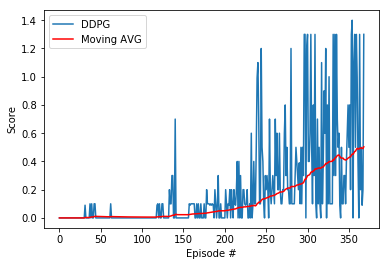

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(max_scores)), max_scores, label='DDPG')
plt.plot(np.arange(len(max_scores)), moving_avgs, c='r', label='Moving AVG')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

In [49]:
# Reload model from checkpoint
checkpoint = torch.load("checkpoint.pt", map_location="cpu")

agent.reset()
agent.actor_local.load_state_dict(checkpoint["actor_local"])
agent.actor_target.load_state_dict(checkpoint["actor_target"])
agent.critic_local.load_state_dict(checkpoint["critic_local"])
agent.critic_target.load_state_dict(checkpoint["critic_target"])

In [50]:
for i in range(5): 
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    steps = 0
    while True:
        steps += 1
        actions = agent.act(states, add_noise=False)       # select an action using the trained agent
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Best score this episode: {}'.format(np.max(scores)))

Best score this episode: 2.7000000402331352
Best score this episode: 2.600000038743019
Best score this episode: 2.600000038743019
Best score this episode: 2.600000038743019
Best score this episode: 2.7000000402331352
